In [79]:
# from IPython.core.display import clear_output
# # install qiskit
# %pip install qiskit
# clear_output()

In [80]:
import networkx as nx
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit_aer import Aer
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram

import numpy as np
from scipy.optimize import minimize

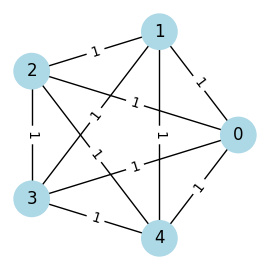

In [81]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

n_nodes = 5
depth = 4
np.random.seed(0)

G = nx.Graph()
G.add_nodes_from(range(n_nodes))
edges = [(i, (i + 1) % n_nodes, 1) for i in range(n_nodes)]
edges.extend([(i, (i + 2) % n_nodes, 1) for i in range(n_nodes)])
G.add_weighted_edges_from(edges)

pos = nx.circular_layout(G)
plt.figure(figsize=(2.5, 2.5))  # 调整图的大小
nx.draw(G, pos, with_labels=True, node_color='lightblue', edgecolors='none', node_size=700, font_size=12, font_color='black', alpha=1, node_shape='o')

edge_labels = {(u, v): data['weight'] for u, v, data in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.savefig("MaxCut_graph_54.svg", format="svg")
plt.show()


In [82]:
def shared_edges(x, Gr):
    """
    根据输入的二进制字符串 x，判断图 Gr 的最大切割问题中被 shared 的边数。

    Parameters:
    - x: str
        二进制字符串，表示图 Gr 的一个切割。
    - Gr: networkx.Graph
        输入的图。

    Returns:
    - int
        共享的边数。
    """
    num_shared_edges = 0

    for edge in Gr.edges():
        if x[edge[0]] != x[edge[1]]:
            # 如果两个节点在不同的切割中，边就是共享的
            num_shared_edges += 1

    return num_shared_edges

In [83]:
from scipy.linalg import expm

GateX = np.array([[0, 1],[1, 0]])
GateY = np.array([[0, -1j],[1j, 0]])
GateZ = np.array([[1, 0],[0, -1]])

def add_in_target(num_qubits, target_qubit, gate=GateZ):
    H = np.eye(2 ** (target_qubit))
    H = np.kron(H, gate)
    H = np.kron(H, np.eye(2 ** (num_qubits - 1 - target_qubit)))
    return H

def generate_Hp():
    # 初始化 Hp 矩阵为零矩阵
    # print(num_qubits)
    Hp = np.zeros((2**n_nodes, 2**n_nodes))
    for pair in list(G.edges()):
      k = pair[0]
      l = pair[1]
      Hp += 1/2*(add_in_target(n_nodes, k) @ add_in_target(n_nodes, l) + np.eye(2**n_nodes))
    return Hp

In [84]:
def build_qaoa_circ(G, theta):
  """
  Creates a QAOA circuit parametrized by theta

  Args:
    G: networkx graph
    theta: list
           parameters for the unitary operators
  
  Returns:
    qc: qiskit circuit
  """
  nqubits = len(G.nodes())
  b_depth = depth # number of "layers" of alternating unitaries
  qc = QuantumCircuit(nqubits)
  beta = theta[:b_depth * n_nodes]
  gamma = theta[b_depth* n_nodes:]

  for i in range(nqubits):
    qc.h(i)
  for j in range(b_depth):
    qc.barrier()
    qc.unitary(expm(-1j * gamma[j] * generate_Hp()), range(n_nodes)) # transpile
    # for pair in list(G.edges()):
    #   k = pair[0]
    #   l = pair[1]
    #   qc.cx(k, l)
    #   qc.rz(gamma[j * len(pair) + k], l)
    #   qc.cx(k, l)
      
    # qc.barrier()
    # mixing unitary
    for i in range(nqubits):
      qc.rx(beta[j * nqubits + i], i)
  qc.measure_all()

  return qc


In [85]:
def cost_function(x, G):
  """
  Given a bitstring x  representing a bipartite, this function returns the number of edges shared between the two partitions of the graph.

  Args:
    x: str
      bitstring representing a birpartite of the graph
    G: networkx graph

  Returns:
    C: float
       cost function of a given partition
  """
  C = 0
  E = G.edges()
  num = [int(char) for char in x]
  for pair in E:
    i = pair[0]
    j = pair[1]
    w = G[i][j]['weight']
    C = C + w * (num[i]*(1-num[j])+num[j]*(1-num[i]))
            
  return C

def compute_expectation(counts, G):
  """
  Computes expectation value based on measurement results
    
  Args:
    counts: dict
            key as bitstring, val as count
           
    G: networkx graph
        
  Returns:
    EV: float
        expectation value
  """
  EV = 0
  total_count = 0
  for x, count in counts.items():
    C = cost_function(x, G)
    EV -= C*count
    total_count += count

  return EV/total_count

def expectation_from_sample(G, shots = 2000):
  """
  Runs the QAOA circuit.

  Args:
    G: networkx graph
    depth: int
           number of "layer"s of unitaries
  """
  backend = Aer.get_backend('qasm_simulator')
  backend.shots = shots

  def execute_circ(theta):
        
    qc = build_qaoa_circ(G, theta)
    counts = backend.run(qc, seed_simulator=10, 
                            shots=shots).result().get_counts()
        
    # print(qc.draw())
    return compute_expectation(counts, G)
    
  return execute_circ

### Minimizing the Cost Function

In [86]:
from scipy.optimize import minimize
import numpy as np

expectation = expectation_from_sample(G)
# 定义你的期望值函数 expectation_from_sample(G)

def callback(x):
    global iteration_count
    iteration_count += 1
    if iteration_count % 10 == 0:
        print(f"Iteration {iteration_count}, Result: {expectation(x)}")

# 随机初始化参数
params = np.random.rand(depth * n_nodes * 2)

# 设定最大迭代次数
max_iterations = 200

# 初始化迭代计数器
iteration_count = 0

# 使用 COBYLA 方法进行最小化，并设置 callback 函数
res = minimize(expectation, params, method='COBYLA', options={'maxiter': max_iterations}, callback=callback)

# 输出最终结果
print("Final Result:", res)


Iteration 10, Result: -4.733
Iteration 20, Result: -4.755
Iteration 30, Result: -5.408
Iteration 40, Result: -5.408
Iteration 50, Result: -5.478
Iteration 60, Result: -5.854
Iteration 70, Result: -5.663
Iteration 80, Result: -5.93
Iteration 90, Result: -5.811
Iteration 100, Result: -4.358
Iteration 110, Result: -5.928
Iteration 120, Result: -5.926
Iteration 130, Result: -5.922
Iteration 140, Result: -5.915
Iteration 150, Result: -5.929
Iteration 160, Result: -5.928
Iteration 170, Result: -5.907
Iteration 180, Result: -5.932
Iteration 190, Result: -5.931
Iteration 200, Result: -5.918
Final Result:  message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -5.934
       x: [ 1.500e+00  6.591e-01 ...  6.988e-01  9.173e-01]
    nfev: 200
   maxcv: 0.0


### Check the Result

In [87]:
from numpy.lib.utils import source
backend = Aer.get_backend('aer_simulator')
backend.shots = 100000
qc_res = build_qaoa_circ(G, res.x)
counts = backend.run(qc_res, seed_simulator=10, shots = 10000).result().get_counts()
counts = dict(sorted(counts.items(), key=lambda x: int(x[0], 2)))
counts

{'00000': 17,
 '00001': 116,
 '00010': 9,
 '00011': 730,
 '00100': 4,
 '00101': 728,
 '00110': 659,
 '00111': 735,
 '01000': 9,
 '01001': 235,
 '01010': 116,
 '01011': 544,
 '01100': 433,
 '01101': 373,
 '01110': 202,
 '01111': 9,
 '10000': 7,
 '10001': 203,
 '10010': 389,
 '10011': 425,
 '10100': 548,
 '10101': 94,
 '10110': 252,
 '10111': 8,
 '11000': 786,
 '11001': 655,
 '11010': 786,
 '11011': 6,
 '11100': 770,
 '11101': 9,
 '11110': 125,
 '11111': 18}

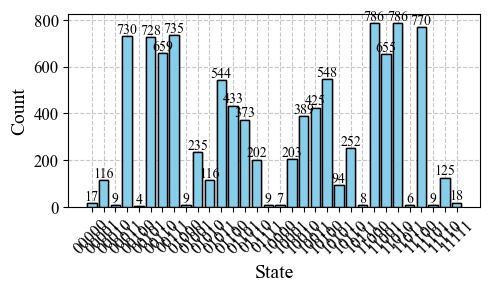

In [88]:
import matplotlib.pyplot as plt


# 提取keys和values
states = list(counts.keys())
values = list(counts.values())

plt.rcParams['font.family'] = 'Times New Roman'
# 创建图形
plt.figure(figsize=(5, 3))
plt.grid(True, linestyle='--', alpha=0.5)  # 降低网格线的透明度

# 绘制柱状图
bars = plt.bar(states, values, color='skyblue', edgecolor='black')

# 绘制柱状图，并添加数值标签
bars = plt.bar(states, values, color='skyblue', edgecolor='black')
plt.bar_label(bars, labels=values, label_type='edge', fontsize=10)  # 添加数值标签

# 设置标题和标签
# plt.title('State Counts', fontsize=16, fontweight='bold')
plt.xlabel('State', fontsize=14)
plt.ylabel('Count', fontsize=14)

# 设置刻度字体
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
# plt.ylim(0, 5490)
# 调整网格线显示顺序
plt.gca().set_axisbelow(True)

# 显示网格线
plt.grid(True, which='both', linestyle='--', alpha=0.7)

# 显示图形
plt.tight_layout()
# plt.savefig("MaxCut_histogram.svg", format="svg")
plt.show()


In [89]:
sorted_counts = sorted(counts, key=counts.get, reverse=True)
for x in sorted_counts[:20]:
  print(x, counts[x], cost_function(x, G))
# qc_res.draw(output='mpl', scale=1, fold=30)

11000 786 6
11010 786 6
11100 770 6
00111 735 6
00011 730 6
00101 728 6
00110 659 6
11001 655 6
10100 548 6
01011 544 6
01100 433 6
10011 425 6
10010 389 6
01101 373 6
10110 252 6
01001 235 6
10001 203 6
01110 202 6
11110 125 4
00001 116 4


In [90]:
result = 0
for x in sorted_counts:
  if cost_function(x, G) == 6:
    result+=counts[x]

print(result)

9663
